## yolov5 추론코드 완성

추론코드(detect.py) 수정 yolov5/detect.py

추론 코드가 매번 import library&model을 해야해서 미리 로드해놓고 바로 추론만 돌아갈 수 있도록 수정

220503

YOLOv5 : https://github.com/ultralytics/yolov5
        
- 설치(torch는 1.8 version)
> 1. git clone https://github.com/ultralytics/yolov5.git
> 2. cd yolov5
> 3. pip install -r requirements.txt

- YOLOv5x 모델 선정
- 입력이미지 640으로 작고, 그 중에 가장 성능이 좋으면서 추론시간 6ms 가능, 88M개의 파라미터 사용

In [ ]:
## parameter 선언
class Myconfig():
    def __init__(self):
        self.weights=['runs/train/exp/weights/best.pt']  # yolov5s.pt
        
        self.intput_path = 'mydata/images/test/영어_2019학년도_6월_25번.jpg'
        self.output_dir = 'output'
        
        self.img_size=640  # inference size (pixels)
        self.conf_thres=0.25  # object confidence threshold
        self.iou_thres=0.45  # IOU threshold for NMS
        self.device=0  # int, 0 or 0,1,2,3 or cpu
#         self.device='cpu'  # int, 0 or 0,1,2,3 or cpu
        
        self.save_img=True  # save images/videos
        self.save_txt=True  # save results to *.txt
        self.save_conf=True  # save confidences in --save-txt labels
        
        self.view_img=False  # display results
        self.classes=[0, 1, 2]  # 4개 class중 3번은 빼고 q, h, a만 출력하자, ['question', 'hint', 'answer', 'total']
        self.agnostic_nms=False  # class-agnostic NMS
        self.augment=False  # augmented inference
        self.update=False  # update all models
        
        self.webcam=False  # webcam을 쓸까말까

    def _print_config(self, config):
        import pprint
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(vars(config))

opt = Myconfig()
opt._print_config(opt)

{   'agnostic_nms': False,
    'augment': False,
    'classes': [0, 1, 2],
    'conf_thres': 0.25,
    'device': 0,
    'img_size': 640,
    'intput_path': 'data_mobu_210812/images/test/영어_2019학년도_6월_25번.jpg',
    'iou_thres': 0.45,
    'output_dir': 'output',
    'save_conf': True,
    'save_img': True,
    'save_txt': True,
    'update': False,
    'view_img': False,
    'webcam': False,
    'weights': ['runs/train/210813_1000/weights/best.pt']}


In [ ]:
## preloader clasee
import os
import time
from pathlib import Path

import torch

import cv2
from numpy import random

from models.experimental import attempt_load

from utils.datasets import LoadImages
from utils.general import check_img_size, set_logging, increment_path, non_max_suppression, scale_coords, xyxy2xywh
from utils.plots import plot_one_box
from utils.torch_utils import select_device, time_synchronized

from IPython.display import Image
import pprint

class inference_yolo_class():
    def __init__(self, opt):
        save_img, weights, view_img, save_txt, imgsz = opt.save_img, opt.weights, opt.view_img, opt.save_txt, opt.img_size

        # input image path
        source = opt.intput_path
        # save path
        if not os.path.isdir(opt.output_dir):  os.mkdir(opt.output_dir)
        self.save_dir = Path(opt.output_dir)

        self.webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))  # for webcam

        # Initialize
        set_logging()
        self.device = 'cpu' if opt.device=='cpu' else 'cuda:%d' % opt.device
        self.half = self.device != 'cpu'  # half precision only supported on CUDA

        print('device : %s'%self.device)

        # Load model
        self.model = attempt_load(weights, map_location=self.device)  # load FP32 model
        self.stride = int(self.model.stride.max())  # model stride, 32
        self.imgsz = check_img_size(imgsz, s=self.stride)  # check img_size, 640
        if self.half:
            print('USE FP16')
            self.model.half()  # to FP16


        # Second-stage classifier, 추가적인 분류기를 사용한다면 여기서 사용, 우리는 안한다
        self.classify = False
        if self.classify:
            modelc = load_classifier(name='resnet101', n=2)  # initialize
            modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=self.device)['model']).to(self.device).eval()

        # Get names and colors
        self.names = self.model.module.names if hasattr(self.model, 'module') else self.model.names  # ['question', 'hint', 'answer', 'total']
        # colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
        # ['question(파랑)', 'hint(선홍)', 'answer(녹색)', 'total(빨강)']
        self.colors = [[0, 0, 255], [255, 255, 0], [0, 255, 0], [255, 0, 0]]

        self.class_mapping = {}  # {0: 'question', 1: 'hint', 2: 'answer', 3: 'total'}
        for idx, class_name in enumerate(self.names):  self.class_mapping[idx]=class_name
        print(self.class_mapping)
        print('pre-load done!!')
        
        
    ## Run inference
    def OD_inference(self, input_path='data_mobu_210812/images/test/국어_2018학년도_6월_42번.jpg'):
        '''
        input : image path(640x640)
        output: list_result_value, ex)
                    [{'class': 'answer',
                    'x_center': '0.503125',
                    'y_center': '0.650781',
                    'width': '0.525',
                    'height': '0.157813',
                    'confidence': '0.974121',
                    'input_path': 'total_210415/images/very_small/영어_2019학년도_4월_26번.jpg'},
                    {'class': 'question',
                    'x_center': '0.53125',
                    'y_center': '0.298438',
                    'width': '0.625',
                    'height': '0.525',
                    'confidence': '0.978027',
                    'input_path': 'total_210415/images/very_small/영어_2019학년도_4월_26번.jpg'}]

        '''
        # Set Dataloader
        vid_path, vid_writer = None, None
        if self.webcam:
            view_img = check_imshow()
            cudnn.benchmark = True  # set True to speed up constant image size inference
            dataset = LoadStreams(input_path, img_size=self.imgsz, stride=self.stride)
        else:
            dataset = LoadImages(input_path, img_size=self.imgsz, stride=self.stride)  # path(folder or img),  640, 32



        if self.device != 'cpu':
            self.model(torch.zeros(1, 3, self.imgsz, self.imgsz).to(self.device).type_as(next(self.model.parameters())))  # run once
        t0 = time.time()
        for idx, (path, img, im0s, vid_cap) in enumerate(dataset):
            if idx > 0: break
            # path # 입력 path, ex) '/home/go/OD/yolov5/total_210415/images/very_small/영어_2019학년도_4월_39번.jpg'
            # img : [3, 640, 640], 0~255
            # im0s : [640, 640, 3]
            img = torch.from_numpy(img).to(self.device)
            img = img.half() if self.half else img.float()  # uint8 to fp16/32
            img /= 255.0  # 0 - 255 to 0.0 - 1.0
            if img.ndimension() == 3:
                img = img.unsqueeze(0)  # [3, 640, 640] -> [1, 3, 640, 640]

            print(idx)


            # Inference
            t1 = time_synchronized()
            # model input : (3, 640, 640), 0~1
            # model output: (1, 25200, 9), 0~649.5
            pred = self.model(img, augment=opt.augment)[0]  # 

            # Apply NMS
            '''
            수많은 추정값을 threshold로 잘라서 보여준다. 너무 자잘하게 많이 나오면 conf_thres를 높여준다
            input : conf_thres:0.25, iou_thres:0.45
            pred : [tensor([[110.50000, 407.25000, 528.00000, 595.00000,   0.97559,   2.00000],
                             [ 95.75000, 378.50000, 534.00000, 600.50000,   0.97314,   3.00000],
                             [102.25000, 383.75000, 363.50000, 402.75000,   0.93896,   0.00000]], device='cuda:0')]    
            '''
            pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
            t2 = time_synchronized()

            # Apply Classifier, 실행 안함
            if self.classify:
                pred = apply_classifier(pred, modelc, img, im0s)


            # Process detections
            list_result_value = []  # 한 이미지의 여러 class 찾은 결과들을 저장
            for i, det in enumerate(pred):  # detections per image
                '''
                det : tensor([[110.50000, 407.25000, 528.00000, 595.00000,   0.97559,   2.00000],
                                [ 95.75000, 378.50000, 534.00000, 600.50000,   0.97314,   3.00000],
                                [102.25000, 383.75000, 363.50000, 402.75000,   0.93896,   0.00000]], device='cuda:0')
                6개로 이루어진 LIST가 여러개 나옴, 이 여러개가 각 추청한것들
                '''
                if self.webcam:  # batch_size >= 1
                    p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
                else:
                    p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

                p = Path(p)  # to Path
                save_path = str(self.save_dir / p.name)  # 'runs/detect/exp33/국어_2017학년도_11월_11번.jpg'
                txt_path = save_path.replace('jpg', 'txt')
                s += '%gx%g ' % img.shape[2:]  # '640x640 '
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh


                if len(det):
                    # Rescale boxes from img_size to im0 size
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                    # Print results
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class
                        s += f"{n} {self.names[int(c)]}{'s' * (n > 1)}, "  # add to string

                    # 저장을 위한 준비
                    for *xyxy, conf, cls in reversed(det):
                        if opt.save_txt:  # Write to file
                            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh, # [0.53125, 0.2984375059604645, 0.625, 0.5249999761581421]
                            line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                            result = (('%g\t' * len(line)).rstrip() % line).split('\t')  # ['0', '0.53125', '0.298438', '0.625', '0.525', '0.978027']
                            result_value = {
                                'class' : self.class_mapping[int(result[0])],  # 0 -> question으로 바꿔줌
                                'x_center' : result[1], 
                                'y_center' : result[2],
                                'width' : result[3],
                                'height' : result[4],
                                'confidence' : result[5],
                                'input_path' : input_path
                            }
                            list_result_value.append(result_value)  # 한 이미지에서 찾은 여러 클래스를 모두 list로 저장

                        if opt.save_img or opt.view_img:  # Add bbox to image
                            label = f'{self.names[int(cls)]} {conf:.2f}'
                            plot_one_box(xyxy, im0, label=label, color=self.colors[int(cls)], line_thickness=3)

                # Print time (inference + NMS)
        #         print(f'{s}Done. ({t2 - t1:.3f}s)')



            # Stream results
            if opt.view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if opt.save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    print('이미지 저장 완료 : %s'%(save_path))
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)        

            if opt.save_txt:  # Write to file
                with open(txt_path, 'w') as f:
                    # class, x_center, y_center, width, height, confidence, path
                    # 0\t0.53125\t0.298438\t0.625\t0.525\t0.978027\t입력이미지경로
                    for line in list_result_value:
                        f.write('\t'.join(list(line.values()))+'\n')                      


        print(f'Done. ({time.time() - t0:.3f}s)')

        return list_result_value, save_path

In [ ]:
%%time
inferencer = inference_yolo_class(opt)

device : cuda:0
Fusing layers... 


Model Summary: 476 layers, 87212152 parameters, 0 gradients, 217.1 GFLOPS


USE FP16
{0: 'question', 1: 'hint', 2: 'answer'}
pre-load done!!
CPU times: user 745 ms, sys: 60.8 ms, total: 806 ms
Wall time: 802 ms


image 1/1 /home/go/OD/yolov5_mobu/data_mobu_210812/images/test/국어_2018학년도_3월_32번.jpg: 0
이미지 저장 완료 : output/국어_2018학년도_3월_32번.jpg
Done. (0.061s)
[{'class': 'question',
  'confidence': '0.954102',
  'height': '0.071875',
  'input_path': 'data_mobu_210812/images/test/국어_2018학년도_3월_32번.jpg',
  'width': '0.679688',
  'x_center': '0.500781',
  'y_center': '0.14375'},
 {'class': 'answer',
  'confidence': '0.966797',
  'height': '0.321875',
  'input_path': 'data_mobu_210812/images/test/국어_2018학년도_3월_32번.jpg',
  'width': '0.6375',
  'x_center': '0.5125',
  'y_center': '0.8'},
 {'class': 'hint',
  'confidence': '0.96875',
  'height': '0.434375',
  'input_path': 'data_mobu_210812/images/test/국어_2018학년도_3월_32번.jpg',
  'width': '0.65',
  'x_center': '0.509375',
  'y_center': '0.4125'}]


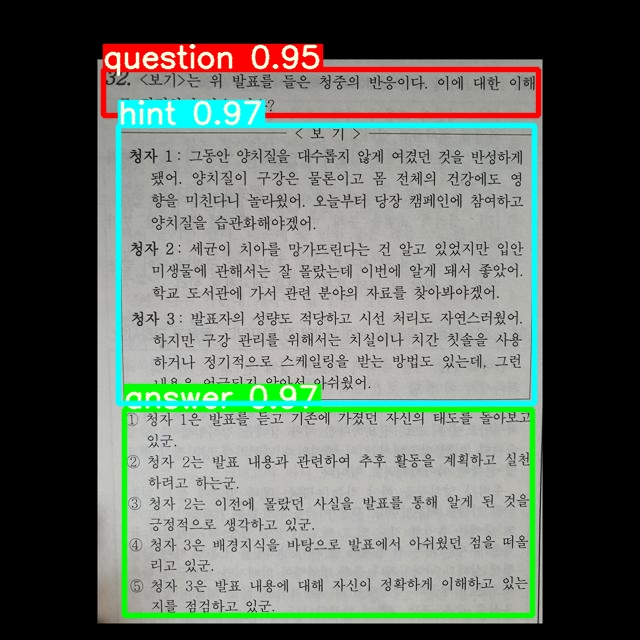

In [ ]:
list_result_value, save_path = inferencer.OD_inference(input_path='data_mobu_210812/images/test/국어_2018학년도_3월_32번.jpg')
pprint.pprint(list_result_value)
Image(filename=save_path, width=600)

image 1/1 /home/go/OD/yolov5_mobu/data_mobu_210812/images/test/수학_2018학년도_6월_12번.jpg: 0
이미지 저장 완료 : output/수학_2018학년도_6월_12번.jpg
Done. (0.070s)
[{'class': 'answer',
  'confidence': '0.91748',
  'height': '0.0375',
  'input_path': 'data_mobu_210812/images/test/수학_2018학년도_6월_12번.jpg',
  'width': '0.646875',
  'x_center': '0.492188',
  'y_center': '0.253125'},
 {'class': 'question',
  'confidence': '0.946777',
  'height': '0.153125',
  'input_path': 'data_mobu_210812/images/test/수학_2018학년도_6월_12번.jpg',
  'width': '0.390625',
  'x_center': '0.35',
  'y_center': '0.135937'}]


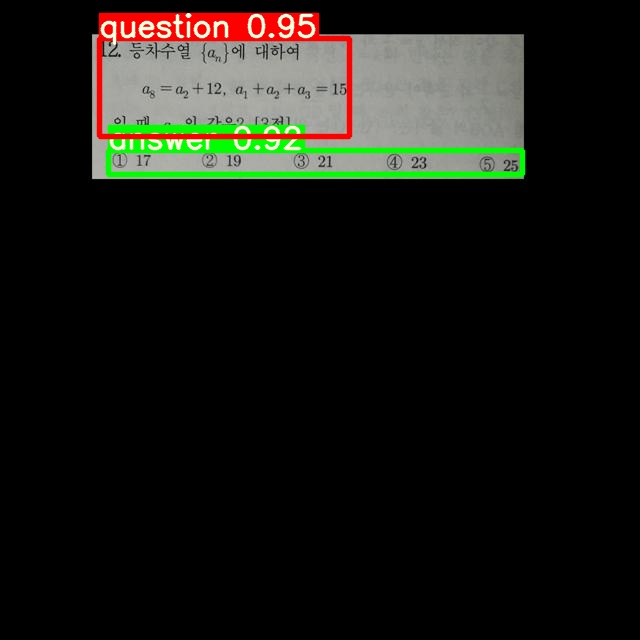

In [ ]:
list_result_value, save_path = inferencer.OD_inference(input_path='data_mobu_210812/images/test/수학_2018학년도_6월_12번.jpg')
pprint.pprint(list_result_value)
Image(filename=save_path, width=600)